In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ['TF_ENABLE_ONEDNN_OPTS']= "0"
# restart kernel

# Model training

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="ignite.handlers.checkpoint")

In [2]:
from itertools import chain

import anndata as ad
# import itertools
import networkx as nx
import pandas as pd
import scanpy as sc
import scglue
import seaborn as sns
from matplotlib import rcParams

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# set up presentation interface
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

In [4]:
# IMPORTANT if Bedtools cannot be found automatically
scglue.config.BEDTOOLS_PATH = '/usr/local/bin'

In [5]:
rna = ad.read_h5ad("../data/GSE126074/GSE126074-RNA_pp.h5ad")
atac = ad.read_h5ad("../data/GSE126074/GSE126074-ATAC_pp.h5ad")
guidance = nx.read_graphml("../result/GSE126074/GLUE_model/guidance.graphml.gz")

## Data configuration

Specify a probabilistic generative model for each dataset.  
- For the scRNA-seq data, use the previously backed up raw counts in the “counts” layer, and use the PCA embedding as the first encoder transformation.  
- For the scATAC-seq data, use the LSI embedding as the first encoder transformation.

In [6]:
%%time
# RNA
scglue.models.configure_dataset(
    rna, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca"
)

# ATAC
scglue.models.configure_dataset(
    atac, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

# use highly-variable features only
guidance_hvf = guidance.subgraph(chain(
    rna.var.query("highly_variable").index,
    atac.var.query("highly_variable").index
)).copy()

CPU times: user 692 ms, sys: 20.3 ms, total: 712 ms
Wall time: 704 ms


## Model training

In [7]:
%%time
glue = scglue.models.fit_SCGLUE(
    {"rna": rna, "atac": atac}, guidance_hvf,
    fit_kws={"directory": "glue"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] autodevice: Using GPU 0 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 27025
[INFO] SCGLUEModel: Setting `max_epochs` = 186
[INFO] SCGLUEModel: Setting `patience` = 16
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 8
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.454, 'g_kl': 0.005, 'g_elbo': 0.458, 'x_rna_nll': 0.165, 'x_rna_kl': 0.006, 'x_rna_elbo': 0.172, 'x_atac_nll': 0.04, 'x_atac_kl': 0.0, 'x_atac_elbo': 0.04, 'dsc_loss': 0.692, 'vae_loss': 0.231, 'gen_loss': 0.196}, val={'g_nll': 0.454, 'g_kl': 0.004, 'g_elbo': 0.459, 'x_rna_nll': 0.165, 'x_rna_kl': 0.006, 'x_rna_elbo': 0.172, 'x_atac_nll': 0.04, 'x_atac_kl': 0.0, 'x_atac_elbo': 0.04, 'dsc_loss':

2025-05-27 02:58:51,367 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "52"...
[INFO] EarlyStopping: Restoring checkpoint "52"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/scglue/data.py:469: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_, resolution=resolution)


[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (17, 18)...
[INFO] estimate_balancing_weight: Estimating balancing weight...


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 27025
[INFO] SCGLUEModel: Setting `align_burnin` = 31
[INFO] SCGLUEModel: Setting `max_epochs` = 186
[INFO] SCGLUEModel: Setting `patience` = 16
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 8
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.415, 'g_kl': 0.004, 'g_elbo': 0.419, 'x_rna_nll': 0.161, 'x_rna_kl': 0.006, 'x_rna_elbo': 0.167, 'x_atac_nll': 0.039, 'x_atac_kl': 0.0, 'x_atac_elbo': 0.04, 'dsc_loss': 0.691, 'vae_loss': 0.223, 'gen_loss': 0.188}, val={'g_nll': 0.415, 'g_kl': 0.004, 'g_elbo': 0.419, 'x_rna_nll': 0.167, 'x_rna_kl': 0.006, 'x_rna_elbo': 0.173, 'x_atac_nll': 0.04, 'x_atac_kl': 0.0, 'x_atac_elbo': 0.04, 'dsc_loss': 0.6

2025-05-27 03:11:20,523 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "70"...
[INFO] EarlyStopping: Restoring checkpoint "70"...
CPU times: user 40min 42s, sys: 1min 16s, total: 41min 58s
Wall time: 20min 45s


In [8]:
# save model if start in the middle
glue.save("../result/GSE126074/GLUE_model/glue.dill")

In [7]:
glue = scglue.models.load_model("../result/GSE126074/GLUE_model/glue.dill")

[INFO] autodevice: Using GPU 0 as computation device.


## Check integration diagnostics

To check whether the integration is reliable, use the built-in metric “integration consistency score” of GLUE to quantifies the consistency between the integration result and the guidance graph.

In [8]:
%%time
dx = scglue.models.integration_consistency(
    glue, {"rna": rna, "atac": atac}, guidance_hvf
)
dx

[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 200 common metacells...
CPU times: user 3min 47s, sys: 54.4 s, total: 4min 41s
Wall time: 3min 2s


,n_meta,consistency
0,10,0.187732
1,20,0.139050
2,50,0.109868
3,100,0.087286
4,200,0.064441


The higher is curve gets, the more confident the integration is. Empirically, assume that the integration is reliable if the curve is above the 0.05 line.

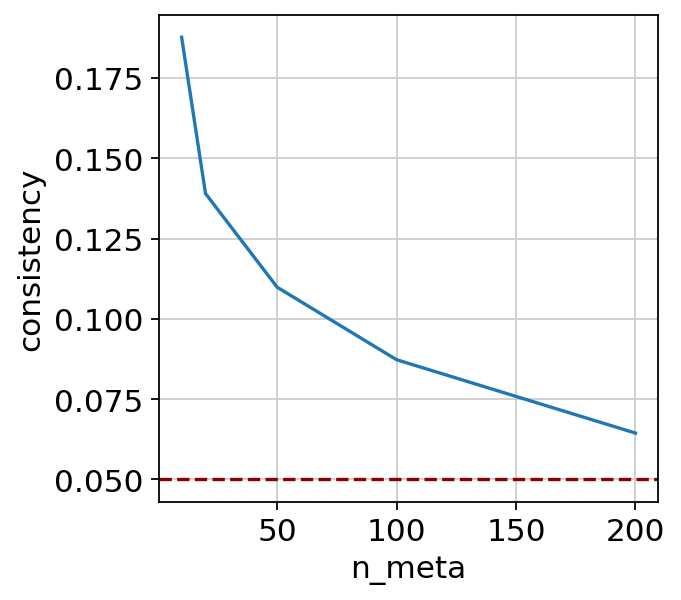

In [10]:
# visualization
_ = sns.lineplot(x="n_meta", y="consistency", data=dx).axhline(y=0.05, c="darkred", ls="--")

## Application of the model

In [16]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)

In [10]:
combined = ad.concat([rna, atac])

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


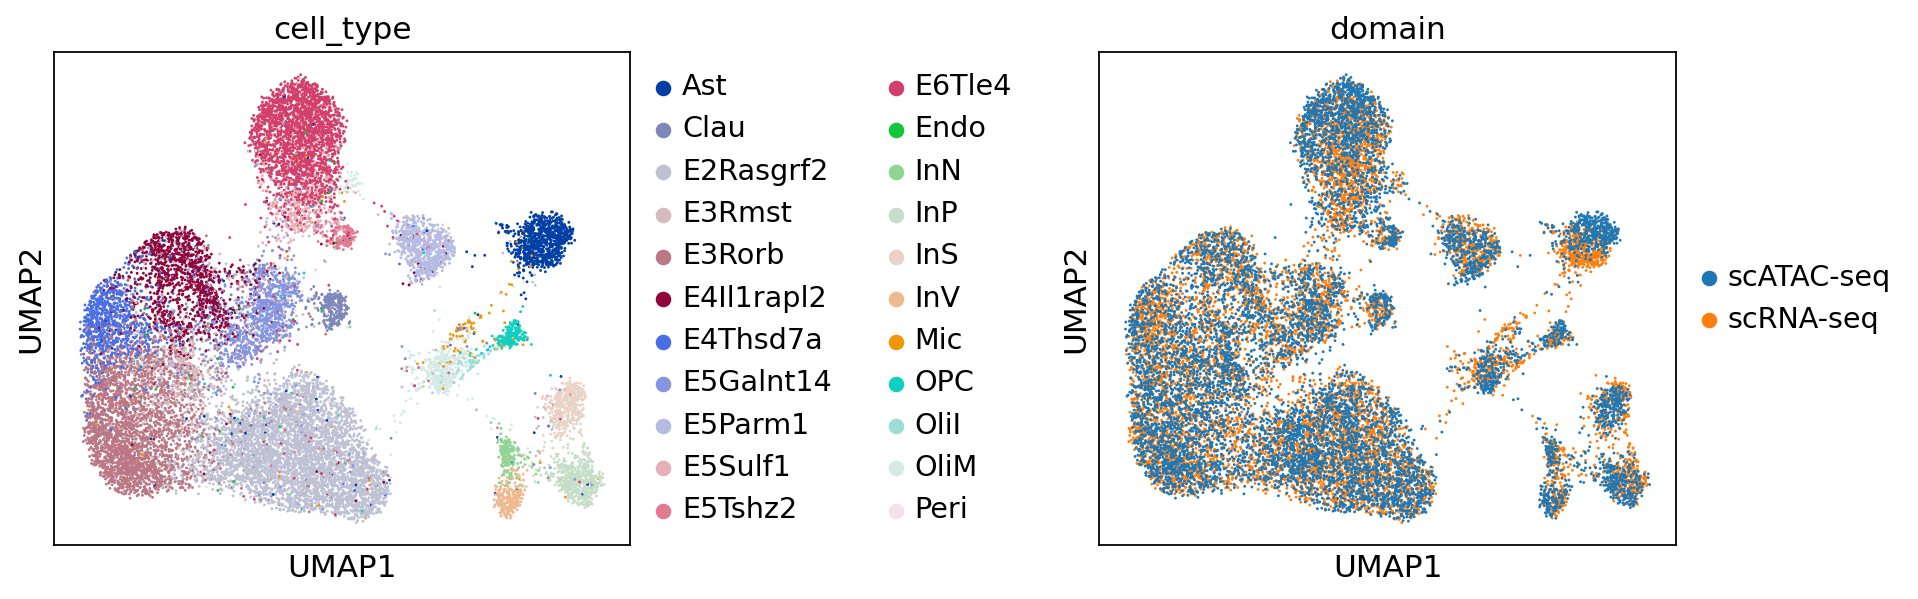

In [13]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)
sc.pl.umap(combined, color=["cell_type", "domain"], wspace=0.65)

In [12]:
feature_embeddings = glue.encode_graph(guidance_hvf)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)

In [13]:
feature_embeddings.shape

(27488, 50)

In [14]:
feature_embeddings = glue.encode_graph(guidance_hvf)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
feature_embeddings.iloc[:5, :5]

,0,1,2,3,4
0610009B22Rik,0.003651,0.055694,-0.003522,0.000047,0.003724
0610025J13Rik,-0.002825,0.055393,0.004325,0.004953,-0.001215
1110002J07Rik,-0.004966,0.097989,-0.004282,0.001248,0.001566
1110006O24Rik,0.006246,0.072847,-0.000853,0.001904,0.003954
1110020A21Rik,-0.006948,-0.157956,-0.000953,0.002014,-0.000773


In [15]:
rna.varm["X_glue"] = feature_embeddings.reindex(rna.var_names).to_numpy()
atac.varm["X_glue"] = feature_embeddings.reindex(atac.var_names).to_numpy()

In [17]:
rna.write("../data/GSE126074/GSE126074-RNA_emb.h5ad", compression="gzip")
atac.write("../data/GSE126074/GSE126074-ATAC_emb.h5ad", compression="gzip")
nx.write_graphml(guidance_hvf, "../result/GSE126074/GLUE_model/guidance-hvf.graphml.gz")

In [25]:
import numpy as np
latent_concat = (rna.obsm["X_glue"], atac.obsm["X_glue"]) / 2
np.savetxt("../result/GSE126074/GLUE.csv", latent_concat, delimiter=',')